In [6]:
# !pip install torch
# !pip install torchvision

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

In [8]:
# VAE Architecture
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        
        # Decoder
        self.fc2 = nn.Linear(latent_dim, 512)
        self.fc3 = nn.Linear(512, 128 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)

    def encode(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        h1 = torch.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = torch.relu(self.fc2(z))
        h2 = torch.relu(self.fc3(h2))
        h2 = h2.view(-1, 128, 4, 4)
        x = torch.relu(self.deconv1(h2))
        x = torch.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [9]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD


In [10]:
# Training the VAE
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    with tqdm(train_loader, unit='batch', desc=f'Epoch {epoch}', colour='green') as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            tepoch.set_postfix(loss=train_loss / len(train_loader.dataset))
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

In [11]:
# Load MNIST dataset and run the training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

vae = ConvVAE(latent_dim=20)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(1, 11):
    train(vae, train_loader, optimizer, epoch)

Files already downloaded and verified


Epoch 1: 100%|██████████| 391/391 [00:35<00:00, 10.92batch/s, loss=704]


Epoch 1, Loss: 704.222931796875


Epoch 2: 100%|██████████| 391/391 [01:13<00:00,  5.29batch/s, loss=585]


Epoch 2, Loss: 584.888950625


Epoch 3: 100%|██████████| 391/391 [00:45<00:00,  8.57batch/s, loss=561]


Epoch 3, Loss: 561.0359325


Epoch 4: 100%|██████████| 391/391 [00:43<00:00,  9.06batch/s, loss=554]


Epoch 4, Loss: 553.6733646875


Epoch 5: 100%|██████████| 391/391 [00:44<00:00,  8.71batch/s, loss=549]


Epoch 5, Loss: 549.42577546875


Epoch 6: 100%|██████████| 391/391 [00:46<00:00,  8.49batch/s, loss=547]


Epoch 6, Loss: 547.14668484375


Epoch 7: 100%|██████████| 391/391 [00:47<00:00,  8.21batch/s, loss=545]


Epoch 7, Loss: 545.244150703125


Epoch 8: 100%|██████████| 391/391 [00:47<00:00,  8.19batch/s, loss=544]


Epoch 8, Loss: 543.78477203125


Epoch 9: 100%|██████████| 391/391 [00:48<00:00,  8.00batch/s, loss=543]


Epoch 9, Loss: 542.72602140625


Epoch 10: 100%|██████████| 391/391 [00:53<00:00,  7.26batch/s, loss=542]

Epoch 10, Loss: 541.9312803125


In [25]:
import matplotlib.pyplot as plt

# Function to generate and display new images
def generate_images(model, num_images=10, latent_dim=20):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim)
        # Decode these points to generate images
        generated_images = []
        for i in tqdm(range(num_images), desc='Generating images', unit='image'):
            generated_image = model.decode(z[i:i+1]).cpu()
            generated_images.append(generated_image)
    # Convert the generated images to a single tensor
    generated_images = torch.cat(generated_images, dim=0)

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        axs[i].imshow(generated_images[i].numpy().transpose(1, 2, 0))
        axs[i].axis('off')
    plt.show()

Generating images: 100%|██████████| 5/5 [00:00<00:00, 341.67image/s]


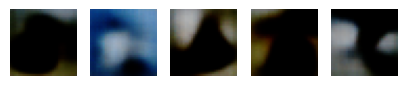

In [26]:
# Assuming you have already trained the model (vae) and it has a latent dimension of 20
generate_images(vae, num_images=5, latent_dim=20)